In [3]:
import pandas as pd
import numpy as np 
import tqdm
import os
import matplotlib.pyplot as plt
import rasterio
import re
import folium
from branca.colormap import LinearColormap

import seaborn as sns

import random

import torch
import torch.nn as nn
from scipy.stats import genextreme, gaussian_kde
from matplotlib.ticker import FuncFormatter

from matplotlib.patches import Rectangle

path = '/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data'

This file presents the main explorations.

# 1- Data Precipitation

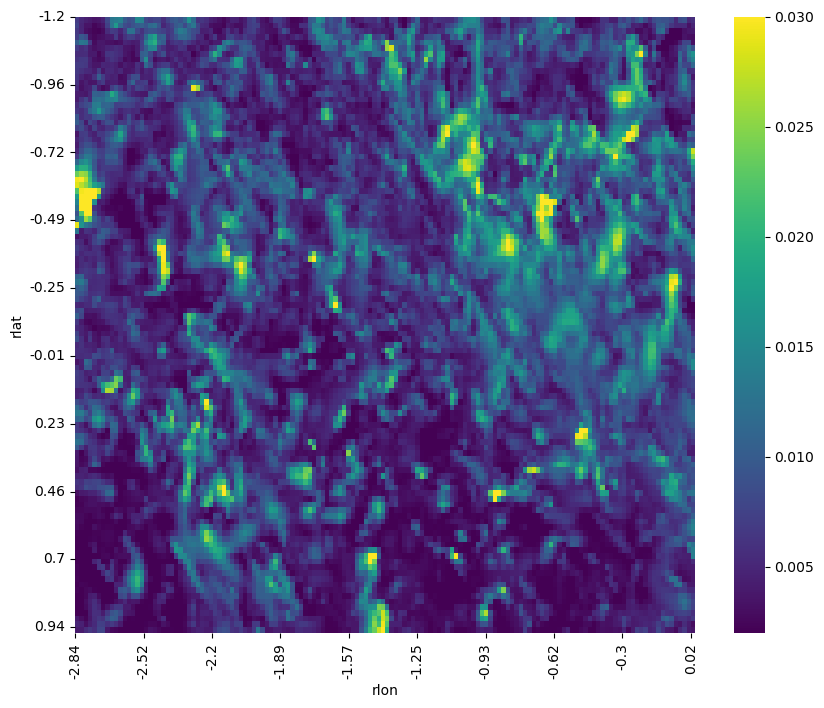

In [4]:
os.chdir(path)
df = pd.read_csv('data2_summer_present_HR.csv')
df = df.loc[(df.year == 2008) & (df.month == 8)]

heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='TOT_PR')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", vmin = 0.002, vmax = 0.03)

num_labels = 10
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()

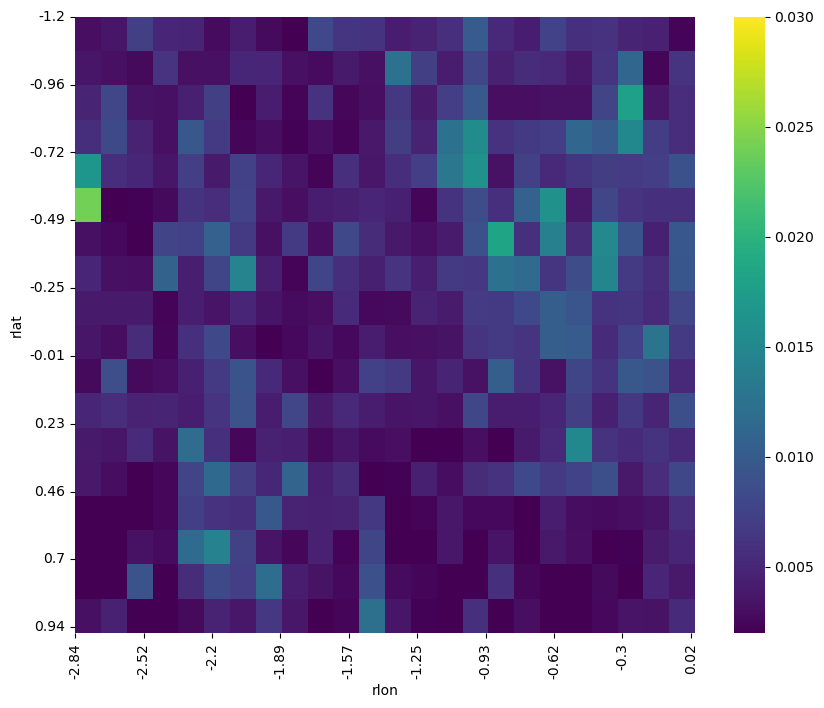

In [5]:
os.chdir('/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data')
df = pd.read_csv('data2_summer_present_LR12.csv')
df = df.loc[(df.year == 2008) & (df.month == 8)]
df = pd.merge(pd.read_csv('Topography/grille2_12.csv'), df, on = ['block'], how = 'left')

heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='TOT_PR')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", vmin = 0.002, vmax = 0.03)

num_labels = 10
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()

# 2- GEV Theory

## Simple examples

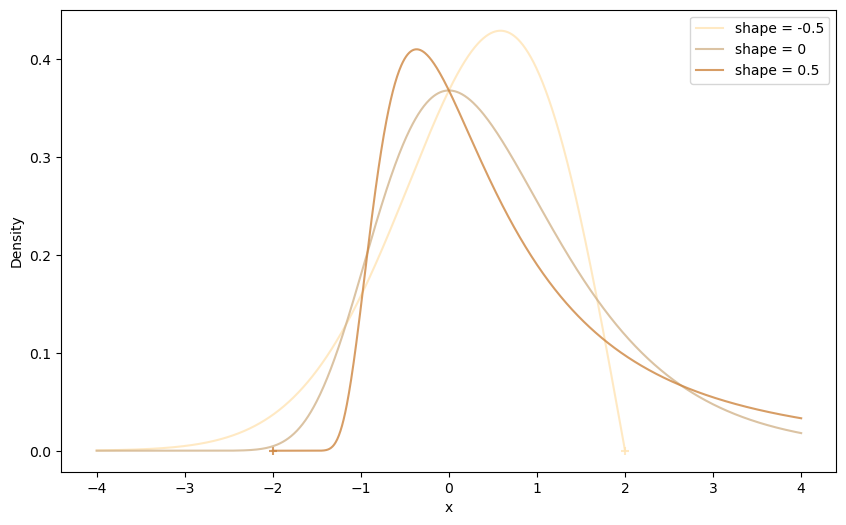

In [6]:
loc = 0
scale = 1
shapes = [-0.5, 0, 0.5]

plt.figure(figsize=(10, 6))
colors = ['moccasin', 'tan', 'peru']
xx = [np.linspace(-4, 2, 1000), np.linspace(-4, 4, 1000), np.linspace(-2, 4, 1000)]
for shape, color, x in zip(shapes, colors, xx):
    y = genextreme.pdf(x, c=-shape, loc=loc, scale=scale)
    plt.plot(x, y, label=f'shape = {shape}', color=color, alpha = 0.8)
plt.scatter([-2], [0], marker = '+', color = 'peru', alpha = 0.8)
plt.scatter([2], [0], marker = '+', color = 'moccasin', alpha = 0.8)

plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
plt.show()


## Application to precipitation

In [9]:
os.chdir('/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data')

df = pd.merge(pd.read_csv('data2_summer_present_HR.csv')[['rlat', 'rlon', 'TOT_PR']],
                pd.read_csv('Topography/grille2_12.csv')[['rlat', 'rlon', 'block']], on = ['rlat', 'rlon'], how = 'left')
nbr_block = np.random.choice(df.block)

df = df.loc[df.block == nbr_block]
df = pd.merge(df, pd.read_csv('data2_12.csv')[['rlat', 'rlon', 'loc1', 'scale1', 'shape1']], on = ['rlat', 'rlon'], how = 'left')
df = pd.merge(df, pd.read_csv('True_Parameters/gev2_param_true_present.csv'), on = ['rlat', 'rlon'], how = 'left')

position = [np.random.choice(df.rlat), np.random.choice(df.rlon)]
position_extreme = df.loc[(df.rlat == position[0]) & (df.rlon == position[1]), 'TOT_PR'].copy()
position_loc, position_scale, position_shape = df.loc[(df.rlat == position[0]) & (df.rlon == position[1]), ['loc', 'scale', 'shape']].iloc[0]
position_shapebi, position_shapebs = df.loc[(df.rlat == position[0]) & (df.rlon == position[1]), ['shape_bi', 'shape_bs']].iloc[0]
df.drop(columns = 'TOT_PR', inplace = True)
df.drop_duplicates(inplace = True)

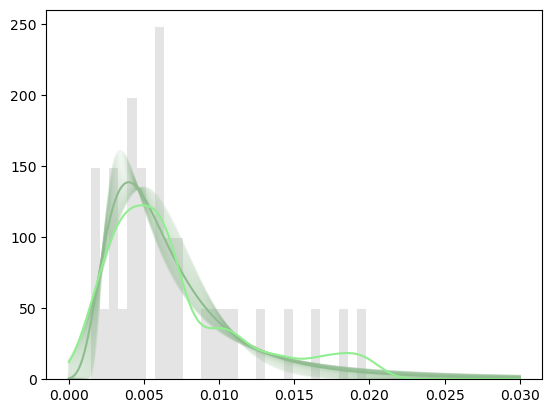

In [10]:
x = np.linspace(0, 0.03, 1000)
plt.hist(position_extreme, bins=30, density=True, alpha=0.6, color='lightgray', label='Density histogram')

for i in np.linspace(position_shapebi, position_shapebs, 50):
    y = genextreme.pdf(x, c=-i, loc=position_loc, scale=position_scale)
    plt.plot(x, y, color='darkseagreen', alpha = 0.1)

y = genextreme.pdf(x, c=-position_shape, loc=position_loc, scale=position_scale)
plt.plot(x, y, label=f'GEV 2 km', color='darkseagreen', alpha = 1)

kde = gaussian_kde(position_extreme)
plt.plot(x, kde(x), label='KDE empirical density', color='lightgreen', linestyle='-')


formatter = FuncFormatter(lambda x, pos: f'{x:.3f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

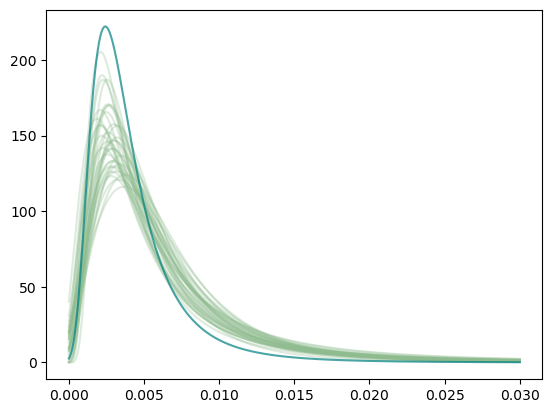

In [241]:
for index, row in df.iterrows():
    y = genextreme.pdf(x, c=-row['shape'], loc=row['loc'], scale=row['scale'])
    plt.plot(x, y, color='darkseagreen', alpha = 0.3)

y = genextreme.pdf(x, c=-row['shape1'], loc=row['loc1'], scale=row['scale1'])
plt.plot(x, y, color='teal', alpha = 0.7)

# 3- Maps of the Parameters 

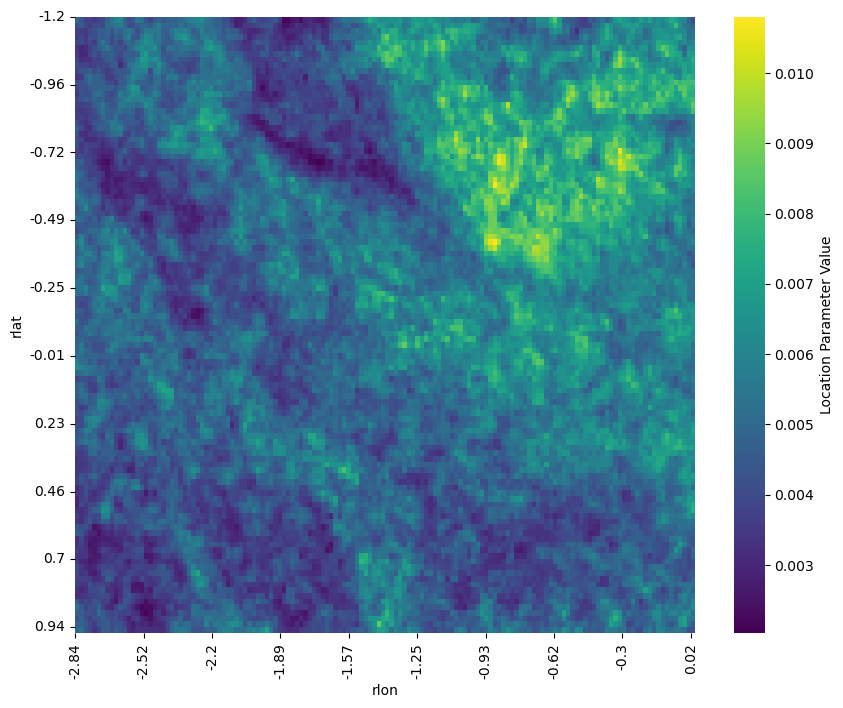

In [584]:
time = 'present' # present ou future peut être inscrit ici 

os.chdir('/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data')
df = pd.read_csv('test_sv_'+time+'_HR.csv')

mean = np.mean(df['loc'])

df['sv_nbr'] = 0
df.loc[(df.sv == 1) & (df['loc'] > mean), 'sv_nbr'] = 3
df.loc[(df.sv == 0) & (df['loc'] > mean), 'sv_nbr'] = 2
df.loc[(df.sv == 0) & (df['loc'] < mean), 'sv_nbr'] = 1

heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='loc')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Location Parameter Value'})


for index, row in df.iterrows():
    if row['sv'] == 1:

        rlat_index = heatmap_data.index.get_loc(row['rlat'])
        rlon_index = heatmap_data.columns.get_loc(row['rlon'])
        
        rect = Rectangle((rlon_index, rlat_index), 1, 1, linewidth=1, edgecolor='white', facecolor='none', hatch='//', alpha = 0.3)
        ax.add_patch(rect)

num_labels = 10
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()


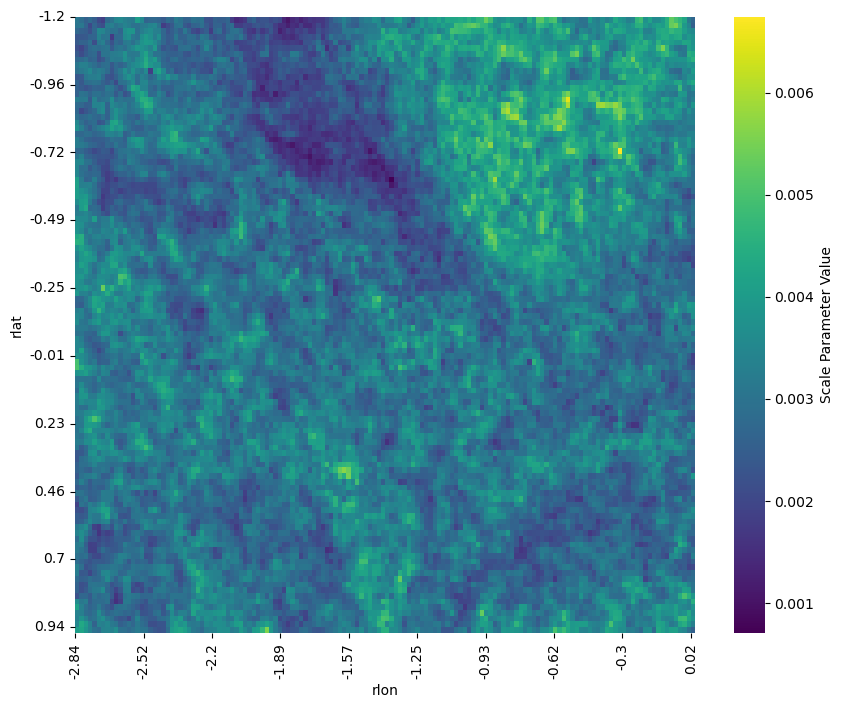

In [456]:
heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='scale')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Scale Parameter Value'})


num_labels = 10
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()

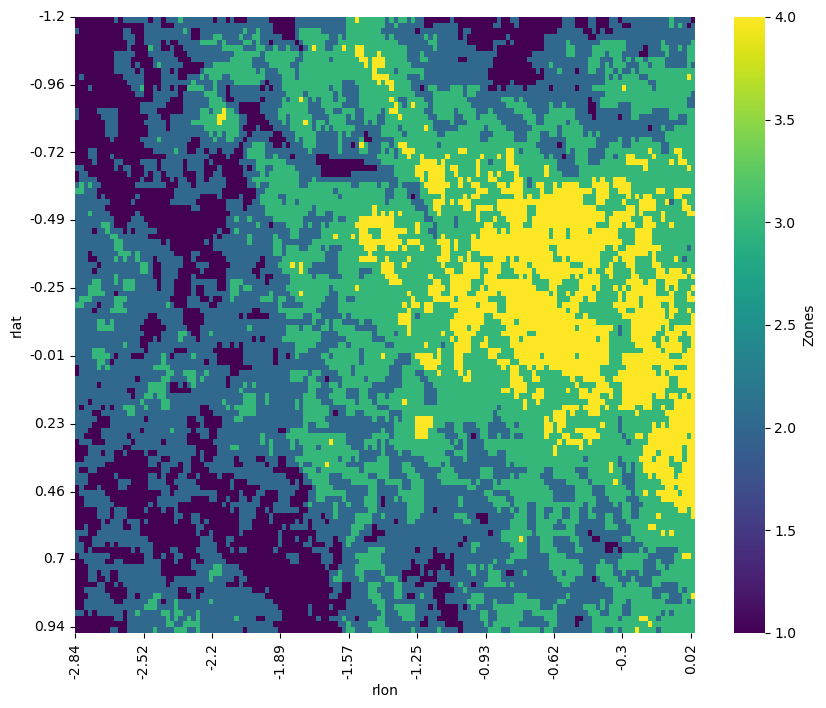

In [474]:
df.sv_nbr = df.sv_nbr + 1
heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='sv_nbr')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Zones'})

num_labels = 10
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()


# Comparaison present and Future

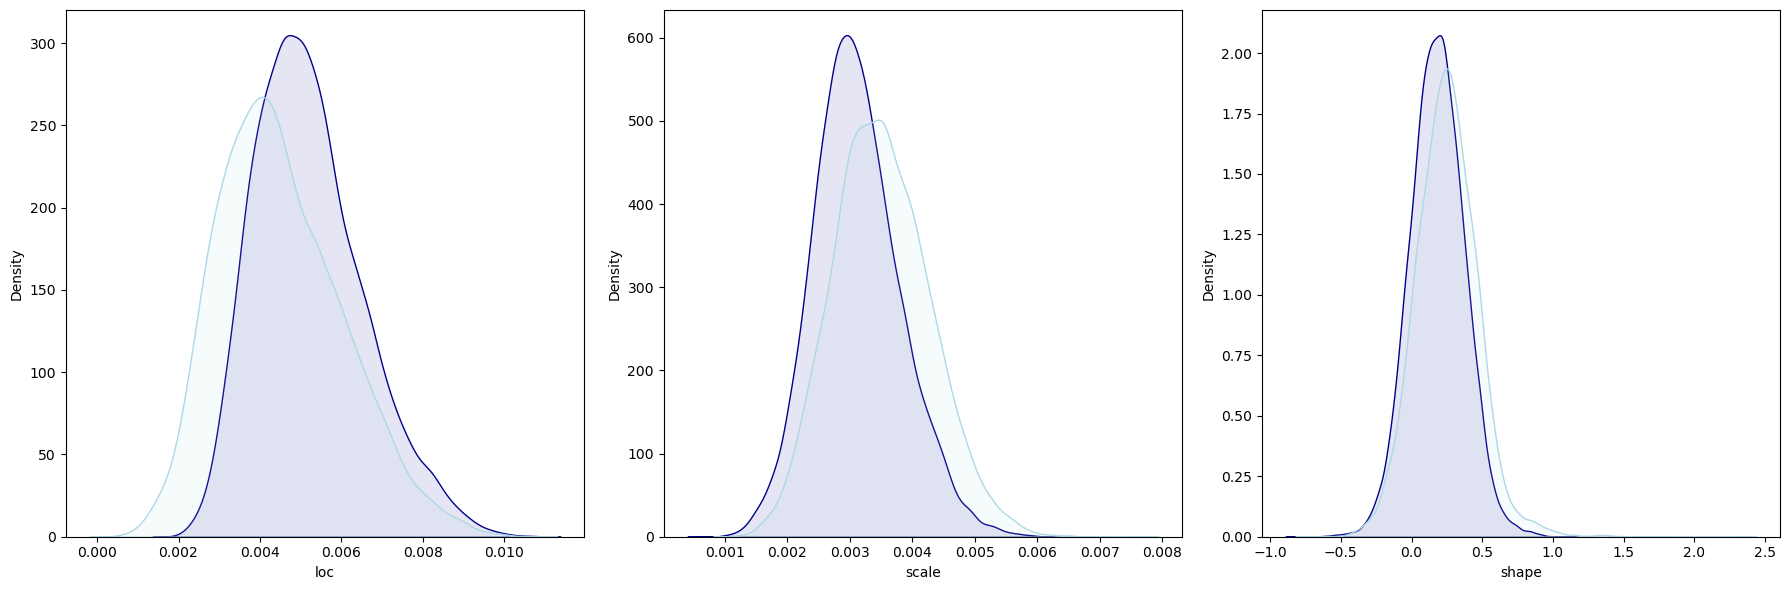

In [512]:
os.chdir('/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data/True_Parameters')
df = pd.read_csv('gev2_param_true_present.csv')
dff = pd.read_csv('gev2_param_true_future.csv')



fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.kdeplot(df['loc'], color='darkblue', fill=True, alpha=0.1, ax=axs[0])
sns.kdeplot(dff['loc'], color='lightblue', fill=True, alpha=0.1, ax=axs[0])
#axs[0].set_title('Density Plot for Loc')

sns.kdeplot(df['scale'], color='darkblue', fill=True, alpha=0.1, ax=axs[1])
sns.kdeplot(dff['scale'], color='lightblue', fill=True, alpha=0.1, ax=axs[1])
#axs[1].set_title('Density Plot for Scale')

sns.kdeplot(df['shape'], color='darkblue', fill=True, alpha=0.1, ax=axs[2])
sns.kdeplot(dff['shape'], color='lightblue', fill=True, alpha=0.1, ax=axs[2])
#axs[2].set_title('Density Plot for Shape')

plt.tight_layout()

plt.show()

# Comparaison of various resolutions

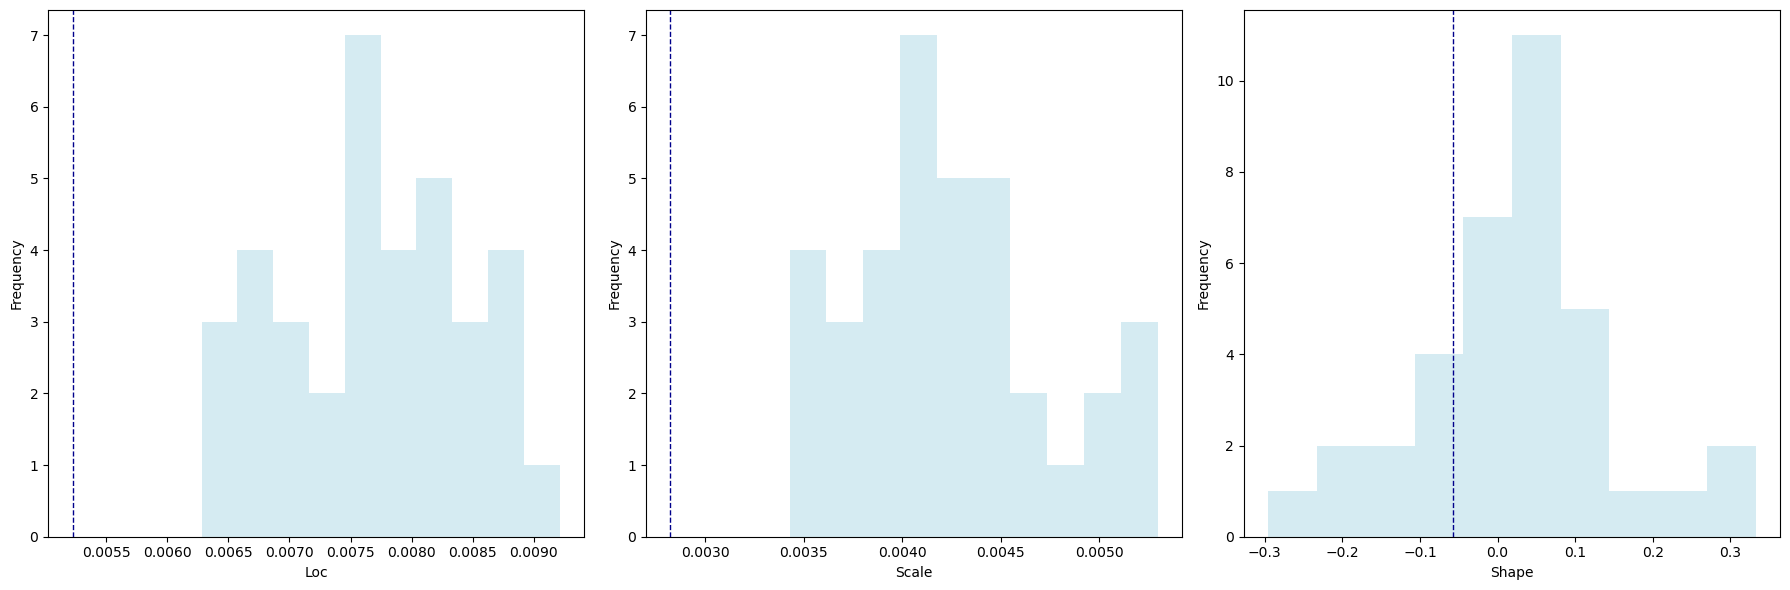

In [510]:
os.chdir('/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data')
df = pd.merge(pd.read_csv('data2_12.csv'),
            pd.read_csv('True_Parameters/gev2_param_true_present.csv'), on = ['rlat', 'rlon'], how = 'left')
df = df[['rlon', 'rlat', 'loc1', 'scale1', 'shape1', 'loc', 'scale', 'shape']]
df.drop_duplicates(inplace = True)

lat = -0.5
lon = -1

df_local = df.loc[(df.rlat == lat) & (df.rlon == lon)]
df = df.loc[df.loc1 == list(df_local.loc1)[0]]


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].hist(df['loc'], alpha=0.5, color='lightblue')
axs[0].axvline(list(df_local.loc1)[0], color='darkblue', linestyle='--', linewidth=1)
axs[0].set_xlabel('Loc')
axs[0].set_ylabel('Frequency')

# Deuxième graphe pour 'scale'
axs[1].hist(df['scale'], alpha=0.5, color='lightblue')
axs[1].axvline(list(df_local.scale1)[0], color='darkblue', linestyle='--', linewidth=1)
axs[1].set_xlabel('Scale')
axs[1].set_ylabel('Frequency')

# Troisième graphe pour 'shape'
axs[2].hist(df['shape'], alpha=0.5, color='lightblue')
axs[2].axvline(list(df_local.shape1)[0], color='darkblue', linestyle='--', linewidth=1)
axs[2].set_xlabel('Shape')
axs[2].set_ylabel('Frequency')

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()

# Afficher les graphiques
plt.show()

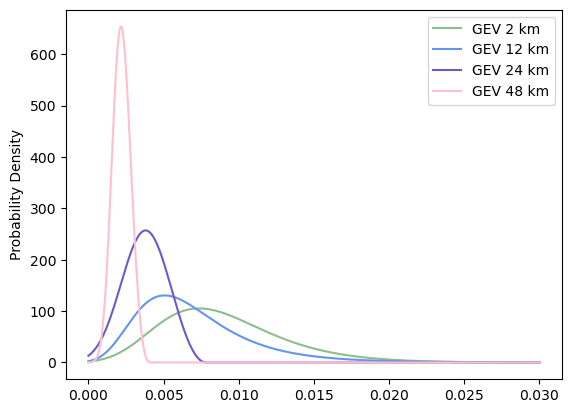

In [259]:
os.chdir('/Users/choupie/Documents/ECCE/Private_Downscaling/0_Base/data')
df = pd.merge(pd.read_csv('data2_12.csv'),
            pd.read_csv('True_Parameters/gev2_param_true_present.csv'), on = ['rlat', 'rlon'], how = 'left')
df = df[['rlon', 'rlat', 'loc1', 'scale1', 'shape1', 'loc', 'scale', 'shape']]
df.drop_duplicates(inplace = True)

lat = -0.5
lon = -1

df = df.loc[(df.rlat == lat) & (df.rlon == lon)]
df.rename(columns = {'loc1' : 'loc12', 'scale1' : 'scale12', 'shape1' : 'shape12'}, inplace = True)
for i in ['24', '48']:
    df = pd.merge(df,
                pd.read_csv('data2_'+i+'.csv')[['rlon', 'rlat', 'loc1', 'scale1', 'shape1']], on = ['rlat', 'rlon'], how = 'left')
    df.rename(columns = {'loc1' : 'loc'+i, 'scale1' : 'scale'+i, 'shape1' : 'shape'+i}, inplace = True)

df.drop_duplicates(inplace = True)

# --- PLOT

x = np.linspace(0, 0.03, 1000)

pdf1 = genextreme.pdf(x, list(df['shape'])[0], loc=list(df['loc'])[0], scale=df.scale[0])
pdf2 = genextreme.pdf(x, df.shape12[0], loc=df.loc12[0], scale=df.scale12[0])
pdf3 = genextreme.pdf(x, df.shape24[0], loc=df.loc24[0], scale=df.scale24[0])
pdf4 = genextreme.pdf(x, df.shape48[0], loc=df.loc48[0], scale=df.scale48[0])

plt.plot(x, pdf1, label='GEV 2 km', c = 'darkseagreen')
plt.plot(x, pdf2, label='GEV 12 km', c = 'cornflowerblue')
plt.plot(x, pdf3, label='GEV 24 km', c = 'slateblue')
plt.plot(x, pdf4, label='GEV 48 km', c = 'pink')


# Ajouter des légendes et des titres

plt.ylabel('Probability Density')
plt.legend()
plt.show()

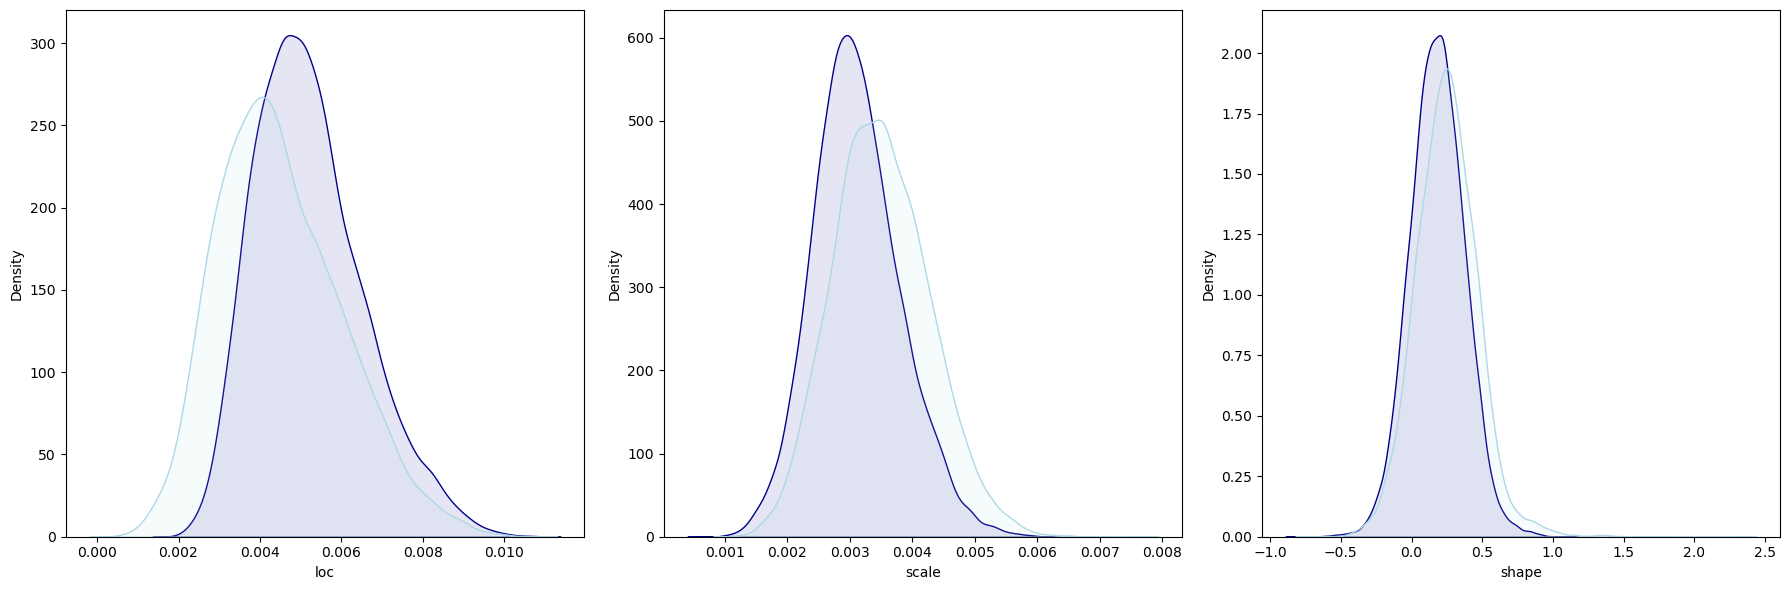

In [511]:


df = pd.read_csv('True_Parameters/gev2_param_true_present.csv')
dff = pd.read_csv('gev2_param_true_future.csv')

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.kdeplot(df['loc'], color='darkblue', fill=True, alpha=0.1, ax=axs[0])
sns.kdeplot(dff['loc'], color='lightblue', fill=True, alpha=0.1, ax=axs[0])
#axs[0].set_title('Density Plot for Loc')

sns.kdeplot(df['scale'], color='darkblue', fill=True, alpha=0.1, ax=axs[1])
sns.kdeplot(dff['scale'], color='lightblue', fill=True, alpha=0.1, ax=axs[1])
#axs[1].set_title('Density Plot for Scale')

sns.kdeplot(df['shape'], color='darkblue', fill=True, alpha=0.1, ax=axs[2])
sns.kdeplot(dff['shape'], color='lightblue', fill=True, alpha=0.1, ax=axs[2])
#axs[2].set_title('Density Plot for Shape')

plt.tight_layout()

plt.show()